<a href="https://colab.research.google.com/github/devpranoy/video_coloriser/blob/master/Pytorch_Video_Coloriser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch Video Coloriser 

Step1

*   Download the model weights
*   Download the video to be colored

Step 2 

*   Preprocessing
*   split into frames



In [2]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

tcmalloc: large alloc 1073750016 bytes == 0x56dee000 @  0x7fb6a4e252a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
0.4.1
True


Using pretrained weights

In [3]:
!git clone https://github.com/devpranoy/video_coloriser coloriser

Cloning into 'coloriser'...
remote: Enumerating objects: 137, done.
remote: Counting objects: 100% (137/137), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 137 (delta 10), reused 129 (delta 8), pack-reused 0
Receiving objects: 100% (137/137), 255.89 KiB | 715.00 KiB/s, done.
Resolving deltas: 100% (10/10), done.


In [4]:

%cd coloriser
!pip install -e .

/content/coloriser
Obtaining file:///content/coloriser
    100% |████████████████████████████████| 1.5MB 14.0MB/s 
    100% |████████████████████████████████| 184kB 26.8MB/s 
    100% |████████████████████████████████| 3.6MB 9.9MB/s 
    100% |████████████████████████████████| 112kB 28.8MB/s 
    100% |████████████████████████████████| 71kB 24.8MB/s 
    100% |████████████████████████████████| 11.6MB 3.4MB/s 
    100% |████████████████████████████████| 92kB 21.6MB/s 
    100% |████████████████████████████████| 61kB 22.1MB/s 
    100% |████████████████████████████████| 81kB 19.7MB/s 
  Running setup.py bdist_wheel for bcolz ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done
  Stored in directory: /root/.cache/pip/wheels/9f/78/26/fb8c0acb91a100dc8914bf236c4eaa4b207cb876893c40b745
  Running setup.py bd

In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2


In [6]:
# Work around with Pillow being preinstalled on these Colab VMs, causing conflicts otherwise.
!pip install Pillow==4.1.1

    100% |████████████████████████████████| 5.7MB 7.1MB/s 
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0


In [7]:
import os
from google.colab import auth
from oauth2client.client import GoogleCredentials
import multiprocessing
from torch import autograd
from fastai.transforms import TfmType
from fasterai.transforms import *
from fastai.conv_learner import *
from fasterai.images import *
from fasterai.dataset import *
from fasterai.visualize import *
from fasterai.callbacks import *
from fasterai.loss import *
from fasterai.modules import *
from fasterai.training import *
from fasterai.generators import *
from fastai.torch_imports import *
from fasterai.filters import *
from pathlib import Path
from itertools import repeat
from google.colab import drive
from IPython.display import Image
import tensorboardX
torch.cuda.set_device(0)
plt.style.use('dark_background')
torch.backends.cudnn.benchmark=True

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:74: RuntimeWarning: The _imaging extension was built for another version of Pillow or PIL
  warnings.warn(str(v), RuntimeWarning)
[autoreload of PIL.Image failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: The _imaging extension was built for another version of Pillow or PIL
]


# Downloading pretrained weights from dropbox

In [0]:
url = "https://www.dropbox.com/s/7r2wu0af6okv280/colorize_gen_192.h5?dl=1"  
import urllib.request
u = urllib.request.urlopen(url)
data = u.read()
u.close()
 
with open("pretrained_weights.h5", "wb") as f :
    f.write(data)

In [0]:
!mkdir colorised_frames

In [10]:
weights_path ='/content/coloriser/pretrained_weights.h5'
results_dir='/content/coloriser/colorised_frames'
#The higher the render_factor, the more GPU memory will be used and generally images will look better.  
#11GB can take a factor of 42 max.  Performance generally gracefully degrades with lower factors, 
#though you may also find that certain images will actually render better at lower numbers.  
#This tends to be the case with the oldest photos.
render_factor=42
filters = [Colorizer34(gpu=0, weights_path=weights_path)]
vis = ModelImageVisualizer(filters, render_factor=render_factor, results_dir=results_dir)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 84358336.97it/s]


# Upload the target video

You can either download the video from youtube or upload a video from the sidebar


In [31]:
!wget "https://iobk.yxwz.xyz/@download/136:140-5c1bd5dad0fe5-mp4:m4a-35884291:2343847-147/mergedstreams/mDf9HkkTHuM/Malayalam%2BMovie%2BSong%2B%257C%2BKaralil%2BKaniyum%2B%257C%2BMariakutty%2B%257C%2BMalayalam%2BFilm%2BSong.mp4" -O "/content/video1.mp4"

--2018-12-20 22:17:33--  https://iobk.yxwz.xyz/@download/136:140-5c1bd5dad0fe5-mp4:m4a-35884291:2343847-147/mergedstreams/mDf9HkkTHuM/Malayalam%2BMovie%2BSong%2B%257C%2BKaralil%2BKaniyum%2B%257C%2BMariakutty%2B%257C%2BMalayalam%2BFilm%2BSong.mp4
Resolving iobk.yxwz.xyz (iobk.yxwz.xyz)... 192.99.32.45
Connecting to iobk.yxwz.xyz (iobk.yxwz.xyz)|192.99.32.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38271060 (36M) [video/mp4]
Saving to: ‘/content/video1.mp4’

/content/video1.mp4 100%[===================>]  36.50M  13.0MB/s    in 2.8s    

2018-12-20 22:17:36 (13.0 MB/s) - ‘/content/video1.mp4’ saved [38271060/38271060]



# Converting a black and white video to frames

In [12]:
!mkdir frames

mkdir: cannot create directory ‘frames’: File exists


In [0]:
import cv2
vidcap = cv2.VideoCapture('/content/video.mp4')
success,image = vidcap.read()
count = 0
while success:
  cv2.imwrite("/content/coloriser/frames/frame%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  count += 1

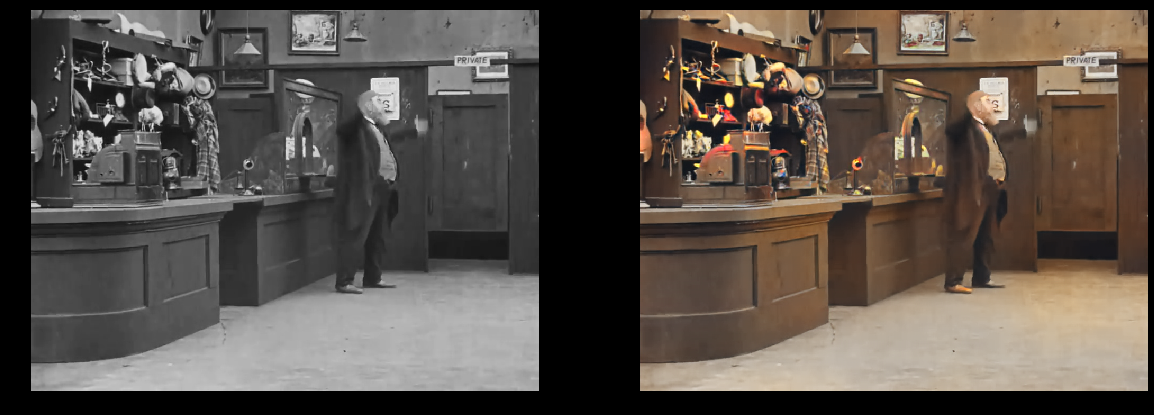

In [14]:
#testing a random frame to optimise render factor/
vis.plot_transformed_image('/content/coloriser/frames/frame267.jpg', render_factor=40)

In [0]:
! rm -rf colorised_frames
! mkdir colorised_frames

In [0]:
import glob
frames = glob.glob("/content/coloriser/frames/*.jpg")


In [17]:
try:
  for i in range(len(frames)):
    vis.frame_transformed_image(frames[i], render_factor=40)
    if i%100 == 0:
      print("%d out of %d"%(i,len(frames)))
      os.system('cls' if os.name == 'nt' else "printf '\033c'")
except:
  print("Final Frame processed")
  
#it gives out some error on the final frame if not in a try catch block. Ignore the error
  

0 out of 1254
100 out of 1254
200 out of 1254
300 out of 1254
400 out of 1254
500 out of 1254
600 out of 1254
700 out of 1254
800 out of 1254
900 out of 1254
1000 out of 1254
1100 out of 1254
1200 out of 1254


# Converting colored frames to video

In [19]:

import cv2
import numpy as np
import os
 
from os.path import isfile, join
 
def convert_frames_to_video(pathIn,pathOut,fps):
    frame_array = []
    files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
 
    #for sorting the file names properly
    files.sort(key = lambda x: int(x[5:-4]))
 
    for i in range(len(files)):
        filename=pathIn + files[i]
        #reading each files
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        #inserting the frames into an image array
        frame_array.append(img)
 
    out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
 
    for i in range(len(frame_array)):
        # writing to a image array
        out.write(frame_array[i])
    out.release()
    
pathIn = '/content/coloriser/colorised_frames/'
pathOut = '/content/coloriser/video_colorised.avi'
fps = 30
convert_frames_to_video(pathIn, pathOut, fps)
print("Completed. Dowload the video from the left navigator under the files section")

Completed. Dowload the video from the left navigator under the files section
